In [2]:
# import needed modules
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
path = '/content/drive/MyDrive/CCPP/Folds5x2_pp.xlsx'

In [5]:
df = pd.read_excel(path)

In [6]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
df.shape

(9568, 5)

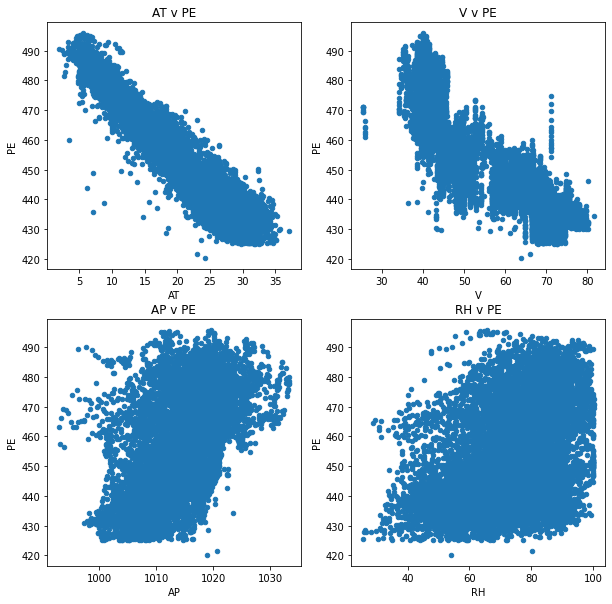

In [8]:
# visualization of data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
df.plot.scatter(ax=axes[0,0], x='AT', y='PE', title='AT v PE')
df.plot.scatter(ax=axes[0,1], x='V', y='PE', title='V v PE')
df.plot.scatter(ax=axes[1,0], x='AP', y='PE', title='AP v PE')
df.plot.scatter(ax=axes[1,1], x='RH', y='PE', title='RH v PE')

The most predictive feature are **AT** and **V** as there is a strong correlation between **AT** and **PE**, **V** and **PE** according ot the plotted scatter plots.

In [9]:
def normalize_data(sample):
  mu = np.mean(sample, axis=0)
  sigma = np.std(sample, axis=0)
  return (sample - mu)/sigma

In [10]:
# search missing values
for col in df.columns:
  if df[col].isna().sum()!=0:
    print(f"columms = {col} has number of missing value: {df[col].isna().sum()}")

In [42]:

def preprocess(data):
  # remove duplicates or missing values
  data = data.drop_duplicates().dropna()
  # suffle data
  data = data.sample(frac=1, random_state=42)
  # get feature and target
  X = data.drop("PE", axis=1).values
  y = data["PE"].values.reshape(len(data), 1)
  # normalization
  X = normalize_data(X)
  return X, y

In [12]:
def split_data(data, split_ratio):
  X, y = preprocess(data)
  # split
  indx = len(data) - int(split_ratio * len(data))
  X_train, y_train = X[:indx], y[:indx]
  X_test, y_test = X[indx:], y[indx:]
  return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = split_data(df, 0.2)

print(f"The train feature shape is : {X_train.shape}")
print(f"The train label shape is : {y_train.shape}")
print(f"The test feature shape is : {X_test.shape}")
print(f"The test label shape is : {y_test.shape}")

The train feature shape is : (7655, 4)
The train label shape is : (7655, 1)
The test feature shape is : (1872, 4)
The test label shape is : (1872, 1)


# Step 2

Considering the following linear hypothesis function:

$$h_i = x_i \theta + b_i $$

Mean Squared Error:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2$$


In [14]:
class LinearRegression:

  def __init__(self, batch_size, max_iters=1000, lr=0.01, tolerance=0.00001):
    self._max_iters = max_iters
    self._lr = lr
    self._tolerance = tolerance
    self._batch_size = batch_size
    # other random variables
    self._theta = None
    self._bias = None

  def mse_loss(self, h, y):
    return np.mean((h - y)**2)

  def d_theta(self, X, h, y):
    n = len(y)
    return (1/n) * X.T @ (h - y)

  def d_bias(self, h, y):
    n = len(y)
    return (1/n) * np.sum(h - y)

  def fit(self, X, y):
    costs, weights, biases = [], [], []
    n, d = X.shape
    num_batches = n // self._batch_size
    self._theta = np.random.rand(d, 1)
    self._bias = np.random.rand(1,1)
    for _ in range(self._max_iters):
      for batch_index in range(0, num_batches, self._batch_size):
        # get batch
        start_index = batch_index
        end_index = batch_index + self._batch_size
        batch_X = X[start_index : end_index]
        batch_y = y[start_index : end_index]
        # get prediction
        batch_h = self.predict(batch_X, self._theta, self._bias)
        # calculate the loss
        curr_loss = self.mse_loss(batch_h, batch_y)
        # update weights and bias
        prev_theta, prev_bias = self._theta, self._bias
        self._theta = self._theta - (self._lr * self.d_theta(batch_X, batch_h, batch_y))
        self._bias = self._bias - (self._lr * self.d_bias(batch_h, batch_y))
        # save values
        weights.append(self._theta)
        biases.append(self._bias)
        costs.append(curr_loss)
        # check early convergence
        diff = np.sum(abs(prev_theta - self._theta)) + np.sum(abs(prev_bias - self._bias))
        if diff <= self._tolerance:
          break
      else:
        continue # continue if inner loop wasn't broken
      break # inner loop was broken, break outer
    return self._theta, costs, weights, biases

  def predict(self, X, theta=None, bias=None):
    if theta is None:
      theta = self._theta
    if bias is None:
      bias = self._bias
    return X @ theta + bias

In [15]:
def plot_learning_curve(costs, title):
  plt.plot(costs)
  plt.xlabel("batches")
  plt.ylabel("cost")
  plt.title(title)
  plt.show()

Batch Gradient Descent

The test MSE is : 22.40419520051177


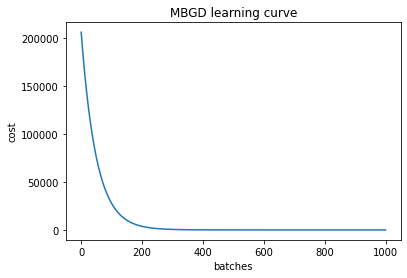

In [102]:
model_BGD = LinearRegression(batch_size=len(X_train), max_iters=1000, lr=0.01, tolerance=0.00001)
theta_BGD, cost_BGD, _, _ = model_BGD.fit(X_train, y_train)  # underscore (_) autre valeur qu'on ne veut pas afficher
# prediction
y_pred_BGD = model_BGD.predict(X_test, theta_BGD)
print(f"The test MSE is : {model_BGD.mse_loss(y_pred_BGD, y_test)}")
# plot curve
plot_learning_curve(cost_BGD, "MBGD learning curve")

In [88]:
y_pred_BGD = model_BGD.predict(X_test, theta_BGD)
model_BGD.mse_loss(y_pred_BGD, y_test)

22.338919310511876

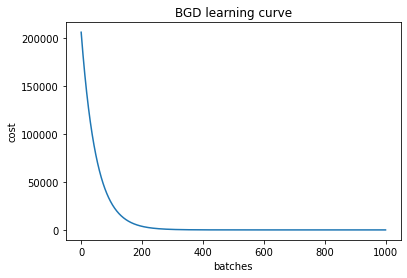

In [89]:
plot_learning_curve(cost_BGD, "BGD learning curve")

Stochastic Gradient Descent

The test MSE is : 21.771575890554356


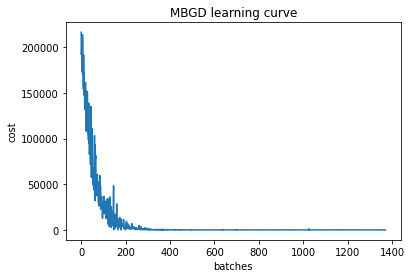

In [98]:
model_SGD = LinearRegression(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001)
theta_SGD, cost_SGD, _, _ = model_SGD.fit(X_train, y_train)
# prediction
y_pred_SGD = model_MBGD.predict(X_test, theta_SGD)
print(f"The test MSE is : {model_SGD.mse_loss(y_pred_SGD, y_test)}")
# plot curve
plot_learning_curve(cost_SGD, "MBGD learning curve")

Mini Batch Gradient Descent

The test MSE is : 21.32299823538865


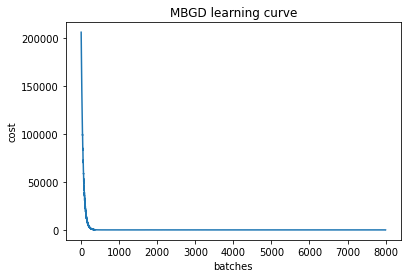

In [96]:
model_MBGD = LinearRegression(batch_size=32, max_iters=1000, lr=0.01, tolerance=0.00001)
theta_MBGD, cost_MBGD, _, _ = model_MBGD.fit(X_train, y_train)
# prediction
y_pred_MBGD = model_MBGD.predict(X_test, theta_MBGD)
print(f"The test MSE is : {model_MBGD.mse_loss(y_pred_MBGD, y_test)}")
# plot curve
plot_learning_curve(cost_MBGD, "MBGD learning curve")

#  Step 3

Considering the following linear hypothesis function:

$$h_i = x_i \theta + b_i $$

MSE + L1 Regularization:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2 + \lambda_1 * \sum_{i=1}^{d} |\theta_i|$$

$$\nabla MSE = \frac{1}{n} \sum_{i=1}^{n} x_i (h_i - y_i) + \lambda_1 *\frac{\theta}{|\theta|}$$


MSE + L2 Regularization:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (h_i - y_i)^2 + \lambda_2 *\sum_{i=1}^{d} (\theta_i)^2$$

$$\nabla MSE = \frac{1}{n} \sum_{i=1}^{n} x_i (h_i - y_i) + \lambda_2 *\theta_i$$


In [16]:
class RegularizedLR(LinearRegression):

  def __init__(self, lamda_1=0, lamda_2=0, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._lamda_1 = lamda_1
    self._lamda_2 = lamda_2

  def mse_loss(self, h, y):
    return super().mse_loss(h, y) + (self._lamda_1 * np.sum(abs(self._theta))) + (self._lamda_2 * np.sum((self._theta)**2))

  def d_theta(self, X, h, y):
    n = len(y)
    return super().d_theta(X, h, y) + (self._lamda_1 * np.sign(self._theta)) + (self._lamda_2 * self._theta)

BGD + L1

The MSE test is : 24.499291552139177


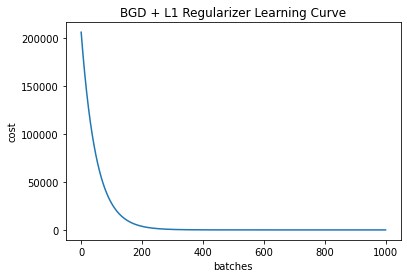

In [114]:
model_L1_BGD = RegularizedLR(batch_size=len(X_train), max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1)
theta_L1_BGD, cost_L1_BGD, _, _ = model_L1_BGD.fit(X_train, y_train)
# prediction
y_L1_pred_BGD = model_L1_BGD.predict(X_test, theta_L1_BGD)
print(f"The MSE test is : {model_L1_BGD.mse_loss(y_L1_pred_BGD, y_test)}")
# plot curve
plot_learning_curve(cost_L1_BGD, "BGD + L1 Regularizer Learning Curve")

BGD + L2

The MSE test is : 51.20909318961252


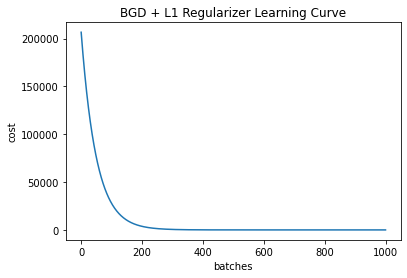

In [118]:
model_L2_BGD = RegularizedLR(batch_size=len(X_train), max_iters=1000, lr=0.01, tolerance=0.00001, lamda_2=0.2)
theta_L2_BGD, cost_L2_BGD, _, _ = model_L2_BGD.fit(X_train, y_train)
# prediction
y_L2_pred_BGD = model_L2_BGD.predict(X_test, theta_L2_BGD)
print(f"The MSE test is : {model_L2_BGD.mse_loss(y_L2_pred_BGD, y_test)}")
# plot curve
plot_learning_curve(cost_L2_BGD, "BGD + L1 Regularizer Learning Curve")

BGD + (L1, L2)

The MSE test is : 46.20199209634676


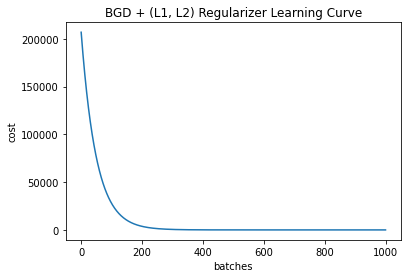

In [121]:
model_L12_BGD = RegularizedLR(batch_size=len(X_train), max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1, lamda_2=0.2)
theta_L12_BGD, cost_L12_BGD, _, _ = model_L12_BGD.fit(X_train, y_train)
# prediction
y_L12_pred_BGD = model_L12_BGD.predict(X_test, theta_L1_BGD)
print(f"The MSE test is : {model_L12_BGD.mse_loss(y_L12_pred_BGD, y_test)}")
# plot curve
plot_learning_curve(cost_L12_BGD, "BGD + (L1, L2) Regularizer Learning Curve")

SGD + L1

The MSE is : 23.16286800401768


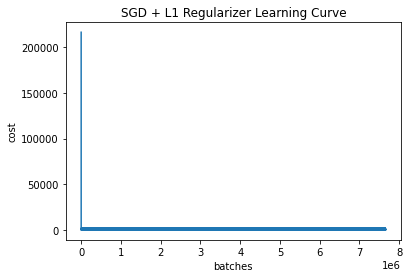

In [124]:
model_L1_SGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1)
theta_L1_SGD, cost_L1_SGD, _, _ = model_L1_SGD.fit(X_train, y_train)
# prediction
y_L1_pred_SGD = model_L1_SGD.predict(X_test, theta_L1_SGD)
print(f"The MSE is : {model_L1_SGD.mse_loss(y_L1_pred_SGD, y_test)}")
# plot curve
plot_learning_curve(cost_L1_SGD, "SGD + L1 Regularizer Learning Curve")

SGD + L2

The MSE is : 51.78046204092982


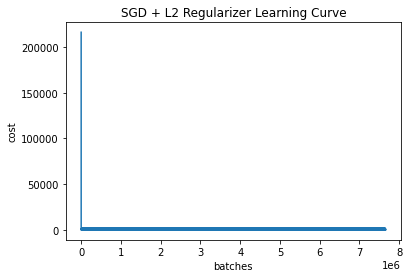

In [125]:
model_L2_SGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_2=0.2)
theta_L2_SGD, cost_L2_SGD, _, _ = model_L2_SGD.fit(X_train, y_train)
# prediction
y_L2_pred_SGD = model_L2_SGD.predict(X_test, theta_L2_SGD)
print(f"The MSE is : {model_L2_SGD.mse_loss(y_L2_pred_SGD, y_test)}")
# plot curve
plot_learning_curve(cost_L2_SGD, "SGD + L2 Regularizer Learning Curve")

SGD + (L1, L2)

The MSE is : 53.52155453200759


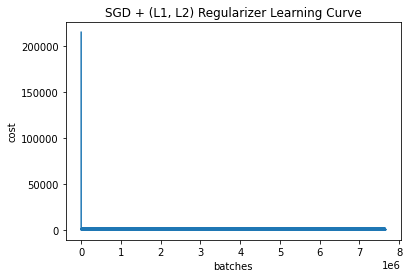

In [126]:
model_L12_SGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1, lamda_2=0.2)
theta_L12_SGD, cost_L12_SGD, _, _ = model_L12_SGD.fit(X_train, y_train)
# prediction
y_L12_pred_SGD = model_L12_SGD.predict(X_test, theta_L12_SGD)
print(f"The MSE is : {model_L12_SGD.mse_loss(y_L12_pred_SGD, y_test)}")
# plot curve
plot_learning_curve(cost_L12_SGD, "SGD + (L1, L2) Regularizer Learning Curve")

MBGD + L1

The MSE is : 23.16286800401768


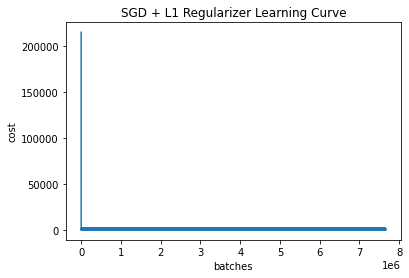

In [127]:
model_L1_MBGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1)
theta_L1_MBGD, cost_L1_MBGD, _, _ = model_L1_MBGD.fit(X_train, y_train)
# prediction
y_L1_pred_MBGD = model_L1_MBGD.predict(X_test, theta_L1_MBGD)
print(f"The MSE is : {model_L1_MBGD.mse_loss(y_L1_pred_MBGD, y_test)}")
# plot curve
plot_learning_curve(cost_L1_MBGD, "SGD + L1 Regularizer Learning Curve")

MBGD + L2

The MSE is : 51.78046204092982


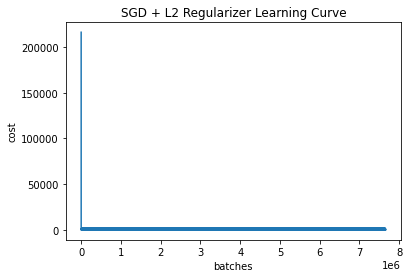

In [128]:
model_L2_MBGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_2=0.2)
theta_L2_MBGD, cost_L2_MBGD, _, _ = model_L2_MBGD.fit(X_train, y_train)
# prediction
y_L2_pred_MBGD = model_L2_MBGD.predict(X_test, theta_L2_MBGD)
print(f"The MSE is : {model_L2_MBGD.mse_loss(y_L2_pred_MBGD, y_test)}")
# plot curve
plot_learning_curve(cost_L2_MBGD, "SGD + L2 Regularizer Learning Curve")

MBGD + (L1, L2)

The MSE is : 53.52155453200759


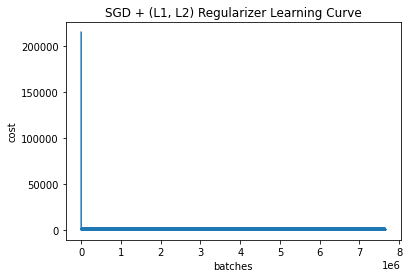

In [129]:
model_L12_MBGD = RegularizedLR(batch_size=1, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=0.1, lamda_2=0.2)
theta_L12_MBGD, cost_L12_MBGD, _, _ = model_L12_MBGD.fit(X_train, y_train)
# prediction
y_L12_pred_MBGD = model_L12_MBGD.predict(X_test, theta_L12_MBGD)
print(f"The MSE is : {model_L12_MBGD.mse_loss(y_L12_pred_MBGD, y_test)}")
# plot curve
plot_learning_curve(cost_L12_MBGD, "SGD + (L1, L2) Regularizer Learning Curve")

For each model in (h), and using lambda in [-10, 10], fit the model and compute the
norm of the weights. Plot the norm of the weights as a function of the regularization
parameter. How does the norm of the weights behave with respect to the weights.
(Ensure lambda=0 is among the set of lambda values)


Print out the weights for the model with the highest norm and lowest norm. How does
the values of the weights (elements of the weights vector) affect the norm?
Print out the weights of an L1-regularization model and L2-regularization model.
What is the difference between the weights? Which model has more sparse weights?

BGD vs $\lambda_1$

100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


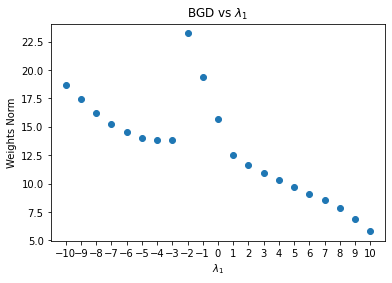

The value of _theta is : [[-5.80309255]
 [-0.01189176]
 [ 0.03682282]
 [-0.01292578]]


In [17]:
values_1 = range(-10, 11)
norm_L1 = []
for lamda_1 in tqdm(values_1):
  model = RegularizedLR(batch_size=32, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_1=lamda_1)
  theta, _, _, _ = model.fit(X_train, y_train)
  norm_L1.append(np.sqrt(np.sum(theta**2)))

plt.scatter(values_1, norm_L1)
plt.xlabel("$\lambda_1$")
plt.ylabel("Weights Norm")
plt.xticks(values_1)
plt.title("BGD vs $\lambda_1$")
plt.show()
print(f"The value of _theta is : {model._theta}")

BGD vs $\lambda_2$

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

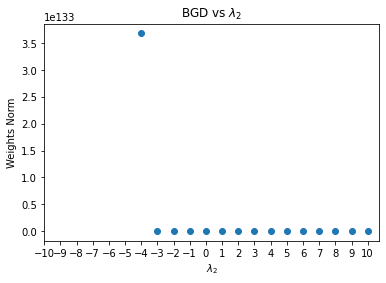

the value of _theta is : [[-1.26615556]
 [-1.18607226]
 [ 0.67944658]
 [ 0.52409457]]


In [18]:
values_2 = range(-10, 11)
norm_L2 = []
for lamda_2 in tqdm(values_2):
  model = RegularizedLR(batch_size=32, max_iters=1000, lr=0.01, tolerance=0.00001, lamda_2=lamda_2)
  theta, _, _, _ = model.fit(X_train, y_train)
  norm_L2.append(np.sqrt(np.sum(theta**2)))

plt.scatter(values_2, norm_L2)
plt.xlabel("$\lambda_2$")
plt.ylabel("Weights Norm")
plt.xticks(values_2)
plt.title("BGD vs $\lambda_2$")
plt.show()
print(f"the value of _theta is : {model._theta}")

**Question**:

What is the difference between the weights? Which model has more sparse weights?

**Answer**:

The weights produced with L1 Regularization are much smaller than the weights produced with L2 Regularization. And the L1 model's weights are much sparse than L2 model's weights. 

# Step 4

Using Mini-batch GD, a 20% test size and a lr of 0.01, fit the training samples, and
predict on the training samples and test samples. Store the MSE error for each
epoch during training in an array. You can write a function to perform this.
Plot the train and test error as a function of the number of epochs. How does the
error behave as the epoch increases?

In [19]:
def plot_loss_curves(model, X_train, y_train, X_test, y_test):
  _, train_costs, weights, biases = model.fit(X_train, y_train)
  test_cost = [model.mse_loss(X_test @ theta + bias, y_test) for theta, bias in zip(weights, biases)]
  # plot learning curve
  plt.plot(train_costs, label="Train loss")
  plt.plot(test_cost, label="Test loss")
  plt.xlabel("batches")
  plt.ylabel("MSE error")
  plt.title("Train loss vs Test loss")
  plt.legend()
  plt.show()

In [20]:
X_train, X_test, y_train, y_test = split_data(df, split_ratio=0.2)

print("Train Features Shape:", X_train.shape)
print("Train Labels Shape  :", y_train.shape)
print("Test Features Shape :", X_test.shape)
print("Test Labels Shape   :", y_test.shape)

Train Features Shape: (7655, 4)
Train Labels Shape  : (7655, 1)
Test Features Shape : (1872, 4)
Test Labels Shape   : (1872, 1)


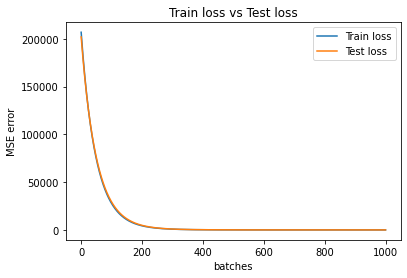

In [23]:
model = LinearRegression(batch_size=128, max_iters=1000, lr=0.01, tolerance=0.00001)
plot_loss_curves(model, X_train, y_train, X_test, y_test)

Using Mini-batch GD and different split sizes in [0.1, 0.9], fit the training samples, and
predict on the training samples and test samples. Store the MSE error for each split
in an array. Use any LR of your choice. You can write a function to perform this.
Plot the train and test error as a function of the split sizes. How does the split size
affect the errors?

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


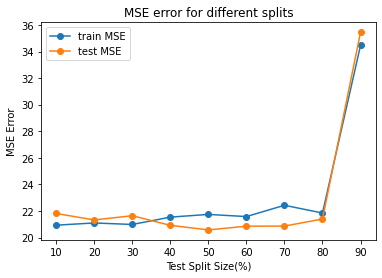

In [25]:
train_mse = []
test_mse = []
split_sizes = np.arange(0.1, 1, 0.1)
model = LinearRegression(batch_size=32, max_iters=1000, lr=0.01, tolerance=0.00001)
for split_size in tqdm(split_sizes):
    X_train, X_test, y_train, y_test = split_data(df, split_ratio=split_size)
    model.fit(X_train, y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), y_test) )

# plot learning curve
plt.plot(split_sizes*100, train_mse, label="train MSE", marker='o')
plt.plot(split_sizes*100, test_mse, label="test MSE", marker='o')
plt.xlabel("Test Split Size(%)")
plt.ylabel("MSE Error")
plt.title("MSE error for different splits")
plt.legend()
plt.show()

Create extra new features of each existing feature by adding polynomial features
of degree 2 to your data. This can be done by squaring each of your previous
features and adding them to the Dataframe. Your total number of features should be
2N where N is the number of previous features. Call the new data, X_poly2.

In [26]:
df_poly2 = df.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2[x+"^2"] = df[x]**2

df_poly2.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244


Add new polynomial features of degree 3 of your initial features to the data. Call
the data X_poly2_3.

In [27]:
df_poly2_3 = df_poly2.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2_3[x+"^3"] = df[x]**3

df_poly2_3.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2,AT^3,V^3,AP^3,RH^3
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528


Add new polynomial features of degree 4 of your initial features to the data. Call
the data X_poly2_3_4

In [28]:
df_poly2_3_4 = df_poly2_3.copy()
for x in df.columns:
    if x == "PE": continue
    df_poly2_3_4[x+"^4"] = df[x]**4

df_poly2_3_4.head()

,AT,V,AP,RH,PE,AT^2,V^2,AP^2,RH^2,AT^3,V^3,AP^3,RH^3,AT^4,V^4,AP^4,RH^4
0,14.96,41.76,1024.07,73.17,463.26,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013,50087.156163,3.041179e+06,1.099812e+12,2.866370e+07
1,25.18,62.96,1020.04,59.08,444.37,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312,401997.084250,1.571299e+07,1.082602e+12,1.218322e+07
2,5.11,39.40,1012.16,92.14,488.56,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344,681.841766,2.409822e+06,1.049534e+12,7.207636e+07
3,20.86,57.32,1010.24,76.64,446.48,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944,189346.471488,1.079505e+07,1.041593e+12,3.450023e+07
4,10.82,37.50,1009.23,96.62,473.90,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528,13705.946842,1.977539e+06,1.037434e+12,8.715015e+07


Using a test size of 20%, calculate the MSE for train and test data using the
different data X(initial data), X_poly2, X_poly2_3, X_poly2_3_4. Plot the train and
test MSE against the degree of polynomial of the features. Use a fixed lambda value
of zero. How does the degree affect fitting of the data?

100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


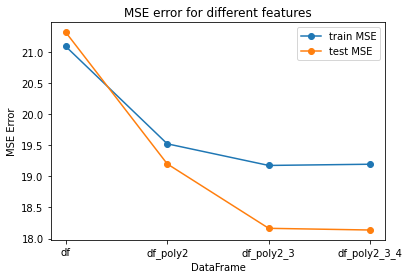

In [29]:
train_mse = []
test_mse = []
split_sizes = np.arange(0.1, 1, 0.1)
model = LinearRegression(batch_size=32, max_iters=1000, lr=0.01, tolerance=0.00001)

for curr_df in tqdm([df, df_poly2, df_poly2_3, df_poly2_3_4]):
    X_train, X_test, y_train, y_test = split_data(curr_df, split_ratio=0.2)
    model.fit(X_train, y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), y_test) )

# plot learning curve
labels = ["df", "df_poly2", "df_poly2_3", "df_poly2_3_4"]
plt.plot(labels, train_mse, label="train MSE", marker='o')
plt.plot(labels, test_mse, label="test MSE", marker='o')
plt.xlabel("DataFrame")
plt.ylabel("MSE Error")
plt.title("MSE error for different features")
plt.legend()
plt.show()

Select the X_poly2_3_4 dataset and regularize the model. What value of lambda
gives the best model and the corresponding MSE on the validation data?

100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


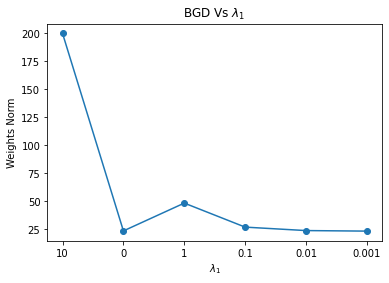

In [33]:
value_1 = [10, 0, 1, 0.1, 0.01, 0.001]
cost_1 = []
X_train, X_test, y_train, y_test = split_data(curr_df, split_ratio=0.2)
for lamda_1 in tqdm(value_1):
    model = RegularizedLR(batch_size=32, max_iters=1000, lr=0.001, tolerance=0.00001, lamda_1=lamda_1)
    model.fit(X_train, y_train)
    test_mse = model.mse_loss(model.predict(X_test), y_test)
    cost_1.append(test_mse)


plt.plot([str(x) for x in value_1], cost_1, marker='o')
plt.xlabel("$\lambda_1$")
plt.ylabel("Weights Norm")
plt.title("BGD Vs $\lambda_1$")
plt.show()

100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


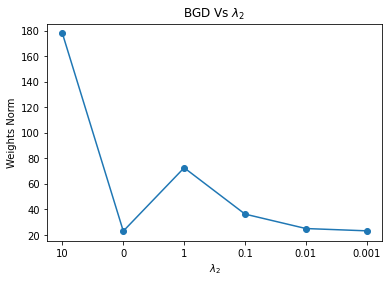

In [34]:
value_2 = [10, 0, 1, 0.1, 0.01, 0.001]
cost_2 = []
X_train, X_test, y_train, y_test = split_data(curr_df, split_ratio=0.2)
for lamda_2 in tqdm(value_2):
    model = RegularizedLR(batch_size=32, max_iters=1000, lr=0.001, tolerance=0.00001, lamda_2=lamda_2)
    model.fit(X_train, y_train)
    test_mse = model.mse_loss(model.predict(X_test), y_test)
    cost_2.append(test_mse)


plt.plot([str(x) for x in value_2], cost_2, marker='o')
plt.xlabel("$\lambda_2$")
plt.ylabel("Weights Norm")
plt.title("BGD Vs $\lambda_2$")
plt.show()

**Question**:

What value of lambda gives the best model and the corresponding MSE on the validation data?

**Answer**:

For both L1 regularization and L2 regularization, the value `0.01` was the one that got the least test MSE.

Using​ Mini-batch SGD​ and learning rates in the range of [1e-9, 2], train your models
for only 3 epoch and compute the training and test losses. Plot the losses as a
function of your learning rate. How does the learning rate affect the convergence rate
and loss of the model? In which learning rate regions, is the model underfitting?

In [37]:
i = 1e-9
learning_rate = []
while(i < 2):
    learning_rate.append(i)
    i *= 10

print(f"learning_rate = {learning_rate}")

learning_rate = [1e-09, 1e-08, 1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0]


100%|██████████| 10/10 [00:00<00:00, 425.42it/s]


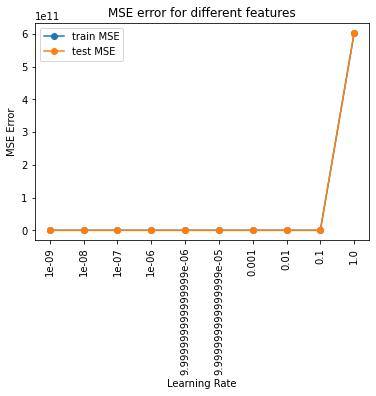

In [38]:
train_mse = []
test_mse = []
X_train, X_test, y_train, y_test = split_data(df, split_ratio=0.2)
for lr in tqdm(learning_rate):
    model = LinearRegression(batch_size=32, max_iters=3, lr=lr, tolerance=0.00001)
    model.fit(X_train, y_train)
    train_mse.append( model.mse_loss(model.predict(X_train), y_train) )
    test_mse.append( model.mse_loss(model.predict(X_test), y_test) )

# plot learning curve
labels = [str(lr) for lr in learning_rate]
plt.plot(labels, train_mse, label="train MSE", marker='o')
plt.plot(labels, test_mse, label="test MSE", marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("MSE Error")
plt.title("MSE error for different features")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Step 5 : Perform Cross validation

The L1 and L2 penalties as we have observed from the previous task have proven to
be some sort of “magic” hyper-parameters which we need to find in order to get a
good performing model. We could alternatively, use the validation set approach, but
this approach also has a major disadvantage: it leaves fewer samples available for
training. Therefore, cross-validation is a better option to overcome this challenge by
using all the training set in a smart way.


Implement your own cross-validation and find the best model based on the different
values of lambda. Refer to your notes for the pseudocode.

In [45]:
def cross_validation(df, kfold):
    folds = []
    X, y = preprocess(df)
    fold_size = len(X)//kfold
    # folds is a list of (trainset, testset) where each item is a tuple of (features, labels)
    for i in range(1, kfold):
        # test set
        test_start_indx = (i-1)*fold_size
        test_end_indx = i*fold_size
        test_features = X[test_start_indx : test_end_indx]
        test_labels = y[test_start_indx : test_end_indx]
        testset = (test_features, test_labels)
        
        # train set
        indx = 0 if i <= 0 else test_start_indx
        train_features = np.concatenate((X[:indx], X[test_end_indx:]), axis=0)
        train_labels =   np.concatenate((y[:indx], y[test_end_indx:]), axis=0)
        trainset = (train_features, train_labels)
        
        folds.append( (trainset, testset) )
    return folds

In [46]:
value_1 = [10, 1, 0.1, 0.01, 0.001]
avg_mse = []
for l1 in tqdm(value_1):
    test_mse = []
    for trainset, testset in cross_validation(df, 7):
        X_train, y_train = trainset
        X_test, y_test = testset
        model = RegularizedLR(batch_size=32, max_iters=1000, lr=0.001, tolerance=0.00001, lamda_1=lamda_1)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        test_mse.append( model.mse_loss(pred, y_test) )
    avg_mse.append( np.mean(test_mse) )
#     break

avg_mse

100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


[27.613151131409214,
 27.481562285157707,
 27.602463352756455,
 27.565094817446575,
 27.75933256639107]

In [47]:
value_1[np.argmin(avg_mse)] #the best value

1